In [29]:
import keras
import os
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing import image
from keras import optimizers
from keras.models import load_model
from sklearn.model_selection import train_test_split
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from keras import backend
from keras.preprocessing import image
from tensorflow.keras import Model

In [2]:
path = '/kaggle/input/clasifiacin-de-enfermedades-del-aguacatero/'
train_metadata = pd.read_csv (path + 'Avocado labels 1.csv')
train_metadata.head()

,Identification,Condition,Healthy,Scab,Anthracnose
0,Avocado 0001,Scab,0,1,0
1,Avocado 0002,Scab,0,1,0
2,Avocado 0003,Healthy,1,0,0
3,Avocado 0004,Scab,0,1,0
4,Avocado 0005,Anthracnose,0,0,1


In [3]:
train_metadata.shape

(3983, 5)

(300, 300, 3)


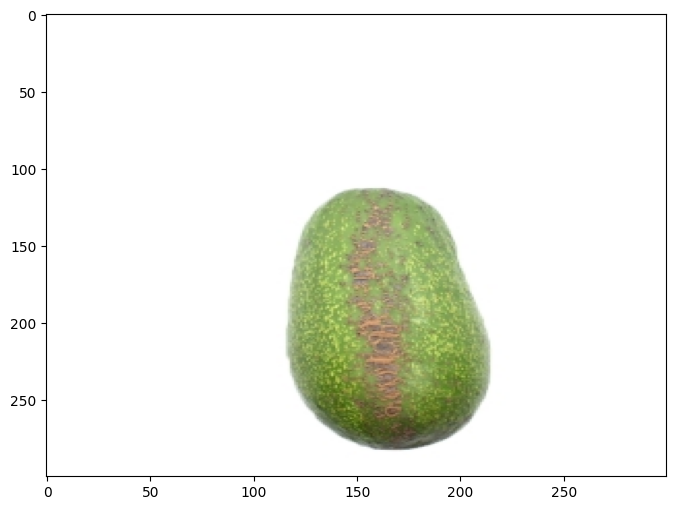

In [4]:
import matplotlib.patches as patches

fig = plt.figure('Images', [8, 6])
path_image = '/kaggle/input/clasifiacin-de-enfermedades-del-aguacatero/Aguacates sin fondo entrenamiento/Aguacates sin fondo entrenamiento/' 

image = plt.imread(path_image + 'Avocado 0001.jpg', format=None)/255.0
print(image.shape)
plt.imshow(image,aspect='auto')
plt.show()

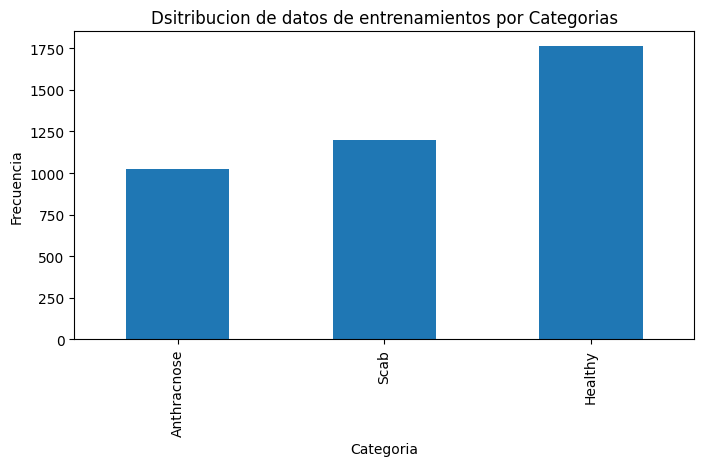

In [5]:
fig = plt.figure('Ejemplos', figsize=[8,4])

train_metadata['Condition'].value_counts().sort_values().plot(kind='bar')
plt.xlabel('Categoria') 
plt.ylabel('Frecuencia') 
  
# displaying the title
plt.title("Dsitribucion de datos de entrenamientos por Categorias")

plt.show()

In [6]:
from numpy.random import seed
import tensorflow
import random
import os

random_seed=2017
seed(random_seed)

tensorflow.random.set_seed(random_seed)

random.seed(random_seed)

os.environ['PYTHONHASHSEED'] = '0'

In [7]:
IN_SHAPE = (128, 128, 3)

In [8]:
def plot_LearningCurve(history,epoch):
    epoch_range = range(1, epoch+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Precisión del Modelo')
    plt.ylabel('Precisión')
    plt.xlabel('Épocas')
    plt.legend(['Entrenamiento', 'Validación'], loc = 'upper left')
    plt.show()
    ###error###
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Pérdida del Modelo')
    plt.ylabel('Pérdida')
    plt.xlabel('Épocas')
    plt.legend(['Entrenamiento', 'Validación'], loc = 'upper left')
    plt.show()

In [9]:
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def get_matrix_report(y_true_test, y_pred_test, class_names):
    f, axes = plt.subplots(figsize=(8, 4))

    disp = ConfusionMatrixDisplay(confusion_matrix(y_true_test,
                                                   y_pred_test),
                                    display_labels=class_names)
    disp.plot(ax=axes, values_format='.4g')
    disp.ax_.set_title(f'class ')

    plt.subplots_adjust(wspace=0.10, hspace=0.1)
    plt.xticks(rotation=90)
    plt.show()

In [30]:
def get_model(pretrained_model, N_clases):
    if pretrained_model.output.shape[1] > 2:
        output = Flatten()(pretrained_model.output)
    else:
        output = pretrained_model.output

    output = GlobalAveragePooling2D()(output)
    output = Dense(512, activation = 'relu')(output)
    output = Dropout(0.5)(output)
    output = Dense(N_clases, activation = 'softmax')(output)
    
#     output = BatchNormalization()(output)
    model = Model(pretrained_model.input, output)
    for layer in pretrained_model.layers:
        layer.trainable = False
        
    model.summary(line_length=200)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
# import tensorflow as tf
# import os

# BATCH_SIZE = 32
# RES_ESPACIAL = 64
# CHANNELS = 3

# def load_data(path,batch_size,res=RES_ESPACIAL):
#     return tf.keras.utils.image_dataset_from_directory(
#         path,
#         labels=None,
#         label_mode=None,
#         color_mode="rgb",
#         batch_size=batch_size,
#         image_size=(res,res),
#         shuffle=False)

In [12]:
# path_train_img = '/kaggle/input/clasifiacin-de-enfermedades-del-aguacatero/Aguacates sin fondo entrenamiento/Aguacates sin fondo entrenamiento/'
# train_images = load_data(path_train_img, batch_size=32, res=RES_ESPACIAL)

In [13]:
# one_hot = train_metadata.drop(['Identification','Condition'], axis = 1)
# one_hot.head()

In [14]:
# ds = tf.data.Dataset.from_tensor_slices(train.drop(['Identification','Condition'],axis = 1))
# combined_dataset = tf.data.Dataset.zip((train_images, ds))
# combined_dataset

### Load data

In [15]:
y = np.array(train_metadata.drop(['Identification','Condition'],axis = 1))

In [16]:
from keras.preprocessing import image
import tensorflow as tf

path_train_img = '/kaggle/input/clasifiacin-de-enfermedades-del-aguacatero/Aguacates sin fondo entrenamiento/Aguacates sin fondo entrenamiento/'
train_image = []

for i in tqdm(range(train_metadata.shape[0])):
    img = image.load_img(path_train_img + train_metadata['Identification'][i]+'.jpg',target_size=IN_SHAPE)
    img = image.img_to_array(img)
    img = img/255.0
    train_image.append(img)
X = np.array(train_image)

100%|██████████| 3983/3983 [00:38<00:00, 102.94it/s]


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [18]:
X_train.shape

(3186, 128, 128, 3)

In [19]:
from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight='balanced', 
                                                 classes=np.unique(np.argmax(y_train, axis = 1)) ,
                                                 y=np.argmax(y_train, axis = 1))

class_weight = {
    0: class_weight[0],
    1: class_weight[1],
    2: class_weight[2]
}

In [20]:
# import absl.logging
# absl.logging.set_verbosity(absl.logging.ERROR)

### CNN CLASIC

In [21]:
model = Sequential()
model.add(Conv2D(filters=8, kernel_size=(3, 3), activation="relu", input_shape=IN_SHAPE))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.30))

model.add(Dense(3, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,579 (385.07 KB)

 Trainable params: 98,579 (385.07 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), 
                    batch_size=32, verbose = 1) # class_weight=class_weight

Epoch 1/25


2024-06-07 20:11:56.674606: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 5.49579, expected 4.72149
2024-06-07 20:11:56.674663: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15884: 6.24612, expected 5.47182
2024-06-07 20:11:56.674696: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15886: 6.40139, expected 5.62709
2024-06-07 20:11:56.674712: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15907: 5.83929, expected 5.06499
2024-06-07 20:11:56.674723: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15912: 6.47502, expected 5.70072
2024-06-07 20:11:56.674733: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15918: 6.13204, expected 5.35774
2024-06-07 20:11:56.674744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15919: 6.47073, expected 5.69643
2024-06-07 20:11:56.674761:

 27/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4242 - loss: 1.0913

I0000 00:00:1717791120.491215     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4451 - loss: 1.0734

2024-06-07 20:12:01.886982: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15879: 5.71897, expected 4.95133
2024-06-07 20:12:01.887040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15880: 6.37642, expected 5.60879
2024-06-07 20:12:01.887049: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15881: 6.04392, expected 5.27628
2024-06-07 20:12:01.887057: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 4.42639, expected 3.65876
2024-06-07 20:12:01.887065: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15883: 6.04203, expected 5.27439
2024-06-07 20:12:01.887072: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15884: 5.61964, expected 4.852
2024-06-07 20:12:01.887080: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15885: 6.37889, expected 5.61125
2024-06-07 20:12:01.887088: E

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4455 - loss: 1.0731

2024-06-07 20:12:07.070073: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.10722, expected 6.28145
2024-06-07 20:12:07.070132: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.97164, expected 6.14586
2024-06-07 20:12:07.070142: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.33415, expected 5.50837
2024-06-07 20:12:07.070149: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.99461, expected 6.16883
2024-06-07 20:12:07.070157: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.53256, expected 5.70678
2024-06-07 20:12:07.070174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 7.06443, expected 6.23866
2024-06-07 20:12:07.070182: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 22: 6.88019, expected 6.05442
2024-06-07 20:12:07.070189: E external/local_xla/xla/

100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.4458 - loss: 1.0728 - val_accuracy: 0.4831 - val_loss: 1.0369
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5140 - loss: 1.0291 - val_accuracy: 0.5044 - val_loss: 0.9586
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5596 - loss: 0.9398 - val_accuracy: 0.5370 - val_loss: 0.8838
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5709 - loss: 0.8885 - val_accuracy: 0.5558 - val_loss: 0.8937
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6043 - loss: 0.8573 - val_accuracy: 0.6349 - val_loss: 0.7949
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6590 - loss: 0.7881 - val_accuracy: 0.6562 - val_loss: 0.7568
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6904 - loss: 0.7126 - val_accuracy: 0.6801 - val_loss: 0.6871
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7013 - loss: 0.6999 - val_accuracy: 0.7039 - va

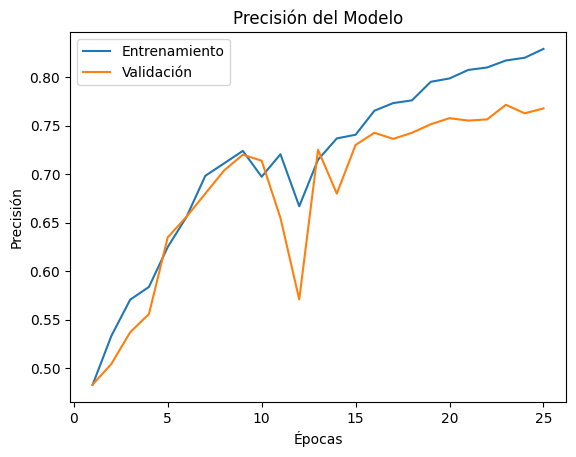

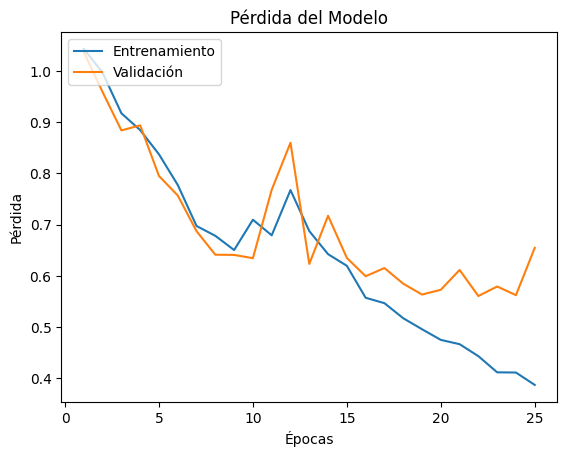

In [25]:
plot_LearningCurve(history, 25)

In [27]:
y_pred = model.predict(X_test)
print(y_pred)
target_names = ['class 0(Healthy)','class 1(Scab)', 'class 2(Anthracnose)']
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1), target_names = target_names))
print(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1)))

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
[[6.97651242e-18 1.00000000e+00 1.06426465e-27]
 [4.21964675e-02 9.57775116e-01 2.84424332e-05]
 [7.49491215e-01 3.21730808e-03 2.47291476e-01]
 ...
 [3.51171754e-02 9.64571595e-01 3.11227341e-04]
 [1.46283919e-05 1.54518045e-03 9.98440206e-01]
 [7.91435003e-01 8.56037834e-04 2.07708985e-01]]
                      precision    recall  f1-score   support

    class 0(Healthy)       0.71      0.94      0.81       336
       class 1(Scab)       0.93      0.83      0.88       252
class 2(Anthracnose)       0.69      0.41      0.52       209

            accuracy                           0.77       797
           macro avg       0.78      0.73      0.73       797
        weighted avg       0.77      0.77      0.75       797

[[317   3  16]
 [ 21 209  22]
 [111  12  86]]


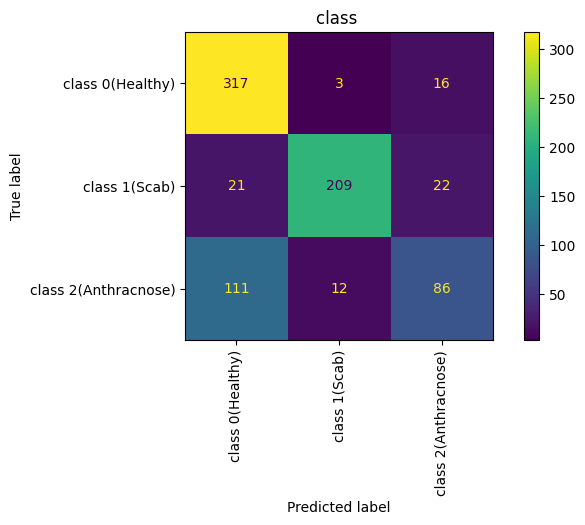

In [28]:
get_matrix_report(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1), target_names)

In [29]:
model.save('/kaggle/working/Avocado_classification.h5')

### Pre trained CNN (ResNet)


In [18]:
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19

In [20]:
pretrained_model = ResNet50(
        include_top=False,
        input_shape=IN_SHAPE,
        weights='imagenet'
    )

model = get_model(pretrained_model, 3)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━
┃ Layer (type)                                              ┃ Output Shape                                      ┃  
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━
│ input_layer_1 (InputLayer)                                │ (None, 128, 128, 3)                               │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv1_pad (ZeroPadding2D)                                 │ (None, 134, 134, 3)                               │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv1_conv (Conv2D)                                       │ (None, 64, 64, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv1_bn (BatchNormalization)                             │ (None, 64, 64, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv1_relu (Activation)                                   │ (None, 64, 64, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ pool1_pad (ZeroPadding2D)                                 │ (None, 66, 66, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ pool1_pool (MaxPooling2D)                                 │ (None, 32, 32, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_1_conv (Conv2D)                              │ (None, 32, 32, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_1_bn (BatchNormalization)                    │ (None, 32, 32, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_1_relu (Activation)                          │ (None, 32, 32, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_2_conv (Conv2D)                              │ (None, 32, 32, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_2_bn (BatchNormalization)                    │ (None, 32, 32, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_2_relu (Activation)                          │ (None, 32, 32, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_0_conv (Conv2D)                              │ (None, 32, 32, 256)                               │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_3_conv (Conv2D)                              │ (None, 32, 32, 256)                               │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2_block1_0_bn (BatchNormalization)                    │ (None, 32, 32, 256)                               │  
├───────────────────────────────────────────────────────

 Total params: 27,914,115 (106.48 MB)

 Trainable params: 4,260,611 (16.25 MB)

 Non-trainable params: 23,653,504 (90.23 MB)

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
history = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=128, class_weight=class_weight, verbose = 1) # callbacks=[es]

Epoch 1/25
 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3438 - loss: 1.9903 

I0000 00:00:1717543294.844547     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 788ms/step - accuracy: 0.4444 - loss: 1.5710 - val_accuracy: 0.4216 - val_loss: 1.7715
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5497 - loss: 0.9888 - val_accuracy: 0.4216 - val_loss: 1.8425
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.5793 - loss: 0.8964 - val_accuracy: 0.4216 - val_loss: 1.5147
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5879 - loss: 0.8880 - val_accuracy: 0.4291 - val_loss: 1.3386
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5947 - loss: 0.8794 - val_accuracy: 0.4228 - val_loss: 1.1854
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.5931 - loss: 0.8588 - val_accuracy: 0.4329 - val_loss: 1.1292
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5989 - loss: 0.8607 - val_accuracy: 0.4893 - val_loss: 1.0590
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.6124 - loss: 0.8557 - val_accuracy: 0.5094 - val_loss: 

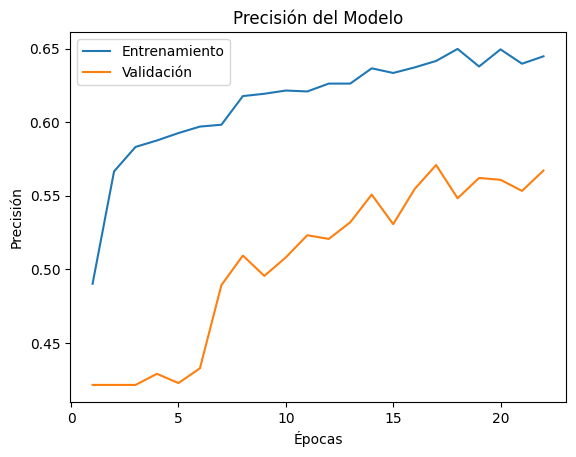

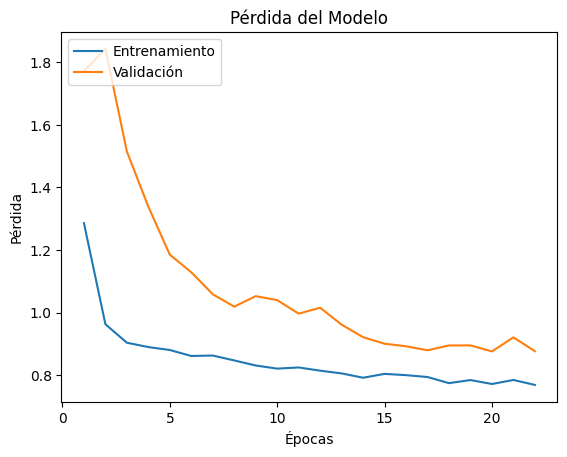

In [23]:
plot_LearningCurve(history, 22)

In [24]:
y_pred = model.predict(X_test)
print(y_pred)
target_names = ['class 0(Healthy)','class 1(Scab)', 'class 2(Anthracnose)']
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1), target_names = target_names))
print(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1)))

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 169ms/step
[[0.36593023 0.2727171  0.3613527 ]
 [0.44610915 0.2068998  0.34699097]
 [0.4814802  0.19591676 0.32260296]
 ...
 [0.6155739  0.19858257 0.18584356]
 [0.01485189 0.09737919 0.88776886]
 [0.51681256 0.15831359 0.3248738 ]]
                      precision    recall  f1-score   support

    class 0(Healthy)       0.54      0.79      0.64       336
       class 1(Scab)       0.69      0.38      0.49       252
class 2(Anthracnose)       0.57      0.45      0.51       209

            accuracy                           0.57       797
           macro avg       0.60      0.54      0.54       797
        weighted avg       0.59      0.57      0.56       797

[[264  36  36]
 [120  96  36]
 [107   7  95]]


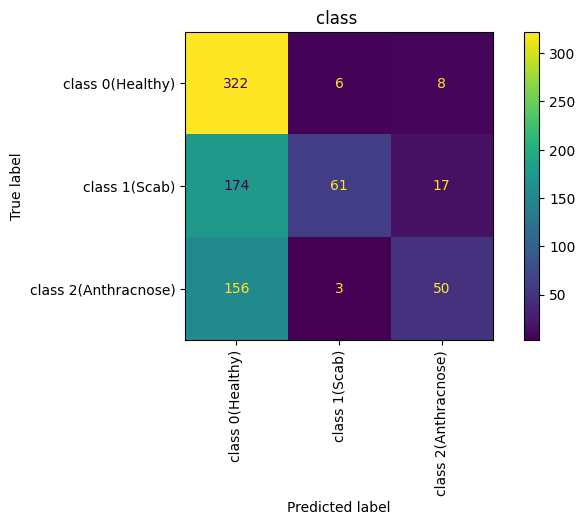

In [44]:
get_matrix_report(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1), target_names)

### Inception 

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# backend.clear_session()

pretrained_model = InceptionV3(
        include_top=False,
        input_shape=IN_SHAPE,
        weights='imagenet'
    )

model_InceptionV3 = get_model(pretrained_model, 3)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━
┃ Layer (type)                                              ┃ Output Shape                                      ┃  
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━
│ input_layer_3 (InputLayer)                                │ (None, 128, 128, 3)                               │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2d_282 (Conv2D)                                       │ (None, 63, 63, 32)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ batch_normalization_282 (BatchNormalization)              │ (None, 63, 63, 32)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ activation_282 (Activation)                               │ (None, 63, 63, 32)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2d_283 (Conv2D)                                       │ (None, 61, 61, 32)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ batch_normalization_283 (BatchNormalization)              │ (None, 61, 61, 32)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ activation_283 (Activation)                               │ (None, 61, 61, 32)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2d_284 (Conv2D)                                       │ (None, 61, 61, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ batch_normalization_284 (BatchNormalization)              │ (None, 61, 61, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ activation_284 (Activation)                               │ (None, 61, 61, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ max_pooling2d_12 (MaxPooling2D)                           │ (None, 30, 30, 64)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2d_285 (Conv2D)                                       │ (None, 30, 30, 80)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ batch_normalization_285 (BatchNormalization)              │ (None, 30, 30, 80)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ activation_285 (Activation)                               │ (None, 30, 30, 80)                                │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ conv2d_286 (Conv2D)                                       │ (None, 28, 28, 192)                               │  
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────────┼──
│ batch_normalization_286 (BatchNormalization)              │ (None, 28, 28, 192)                               │  
├───────────────────────────────────────────────────────

 Total params: 22,853,411 (87.18 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint

es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, mode='max')
history = model_InceptionV3.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), 
                                batch_size=128, class_weight=class_weight, verbose = 1) # callbacks=[es]

Epoch 1/25
 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.2895 - loss: 7.1443

I0000 00:00:1717876353.218966     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.4393 - loss: 5.1201 - val_accuracy: 0.7014 - val_loss: 0.7583
Epoch 2/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.6899 - loss: 0.7532 - val_accuracy: 0.7302 - val_loss: 0.6466
Epoch 3/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7273 - loss: 0.6572 - val_accuracy: 0.7453 - val_loss: 0.6244
Epoch 4/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7497 - loss: 0.6026 - val_accuracy: 0.7578 - val_loss: 0.5785
Epoch 5/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7592 - loss: 0.5610 - val_accuracy: 0.7541 - val_loss: 0.5760
Epoch 6/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7828 - loss: 0.5387 - val_accuracy: 0.7578 - val_loss: 0.5463
Epoch 7/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7853 - loss: 0.5383 - val_accuracy: 0.7704 - val_loss: 0.5421
Epoch 8/25
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7877 - loss: 0.5108 - val_accuracy: 0.7729 - val_loss: 0.5

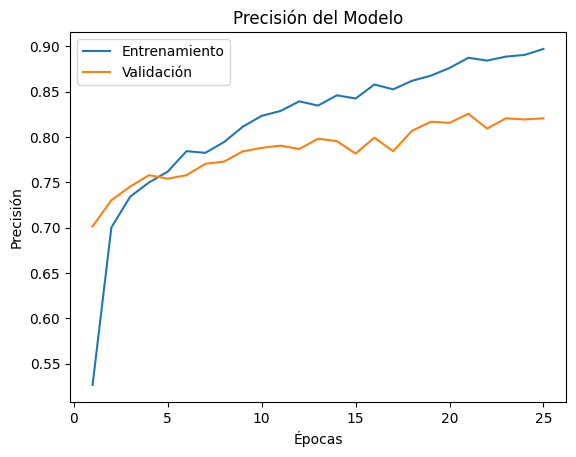

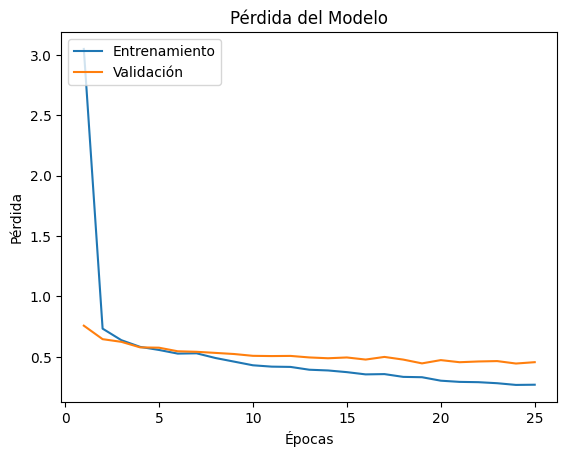

In [33]:
plot_LearningCurve(history, 25)

In [34]:
y_pred = model_InceptionV3.predict(X_test)
print(y_pred)
target_names = ['class 0(Healthy)','class 1(Scab)', 'class 2(Anthracnose)']
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1), target_names = target_names))
print(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1)))

25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step
[[2.5522868e-05 9.9994814e-01 2.6318492e-05]
 [1.7470434e-04 4.0975782e-01 5.9006745e-01]
 [5.1485819e-01 2.3681894e-02 4.6145990e-01]
 ...
 [4.0563661e-01 5.9436005e-01 3.2957628e-06]
 [7.6760486e-08 2.2726861e-05 9.9997723e-01]
 [2.5896153e-01 1.5415032e-03 7.3949695e-01]]
                      precision    recall  f1-score   support

    class 0(Healthy)       0.80      0.88      0.84       336
       class 1(Scab)       0.92      0.79      0.85       252
class 2(Anthracnose)       0.75      0.76      0.75       209

            accuracy                           0.82       797
           macro avg       0.82      0.81      0.81       797
        weighted avg       0.83      0.82      0.82       797

[[296   8  32]
 [ 31 199  22]
 [ 41   9 159]]


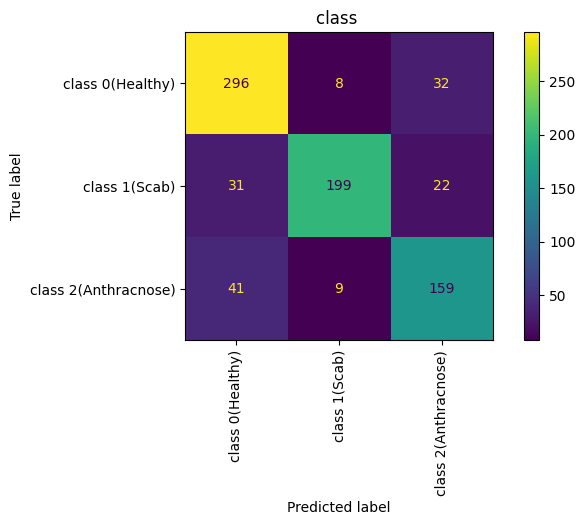

In [35]:
get_matrix_report(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1), target_names)

In [37]:
model_InceptionV3.save('/kaggle/working/Avocado_classification_Inception_v1.h5')

### VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

backend.clear_session()

pretrained_model = VGG16(
        include_top=False,
        input_shape=IN_SHAPE,
        weights='imagenet'
    )

model_InceptionV3 = get_model(pretrained_model, 3)